In [1]:
import numpy as np
import csv
import os
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
nteams = 20
nmatches = (nteams-1)*2

Data Pre-processing

In [3]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [4]:
def season_game_mat(season_dir, team_map):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if '/1-' in entry.path:
            csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        next(reader)
        for row in reader:
            team1 = team_map[row[1]]
            team2 = team_map[row[2]]

            score = row[3].split('-')

            game_mat[team1, team_index[team1]] = int(score[0]) - int(score[1])
            game_mat[team2, team_index[team2]] = int(score[1]) - int(score[0])

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [5]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1

In [6]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [7]:
def ternarize(x):
    if(x > 0.5):
        return 1
    if(x < -0.5):
        return -1
    return 0

def disc_error(outputs, targets):
    ternarize_fn = np.vectorize(ternarize)
    ternarized_outputs = ternarize_fn(np.round(outputs))
    ternarized_targets = ternarize_fn(np.round(targets))
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(ternarized_outputs[i][j]) != int(ternarized_targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [8]:
ntraining = 45
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntraining:]

In [9]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for game_mat in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_training.append(game_mat[j+i])
    
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [10]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for game_mat in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_testing.append(game_mat[j+i])
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [11]:
layer_sizes = [30, 50, 100, 200]

In [12]:
nns = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    nns[key] = []

In [13]:
for i in range(nmatches-1):
    for size in layer_sizes:
        key = str(size)+'_neuron_layers'       
        nn = MLPRegressor(hidden_layer_sizes=(size,2), solver='lbfgs')
        nn.fit(X_trainings[i], Y_trainings[i])
        nns[key].append(nn)

In [14]:
def score(key):
    training_accs = []
    training_errs = []

    with open('nn_nt_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        for i in range(nmatches-1):
            outputs = nns[key][i].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('nn_nt_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        for i in range(nmatches-1):
            outputs = nns[key][i].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [15]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [16]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    score(key)

In [20]:
def plot(y, ylabel, title, imname, ylim):
    x = range(1,nmatches)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,nmatches,0,ylim])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('nnntplots/' + imname + '.png')
    plt.show()

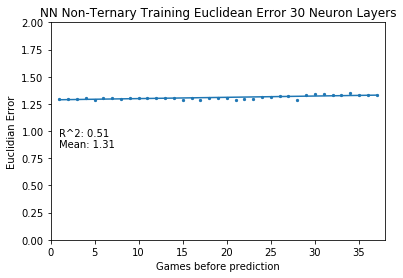

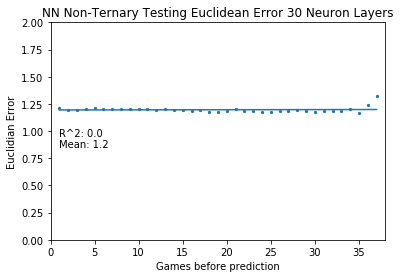

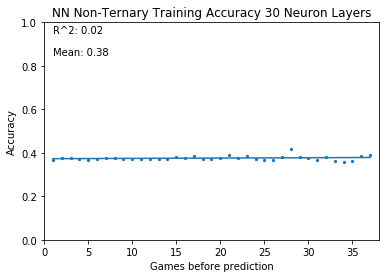

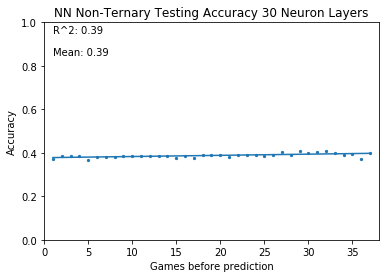

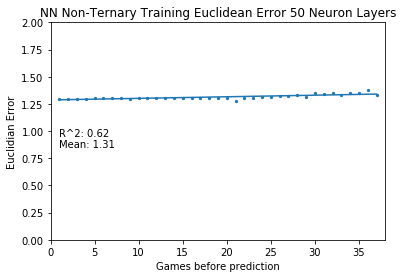

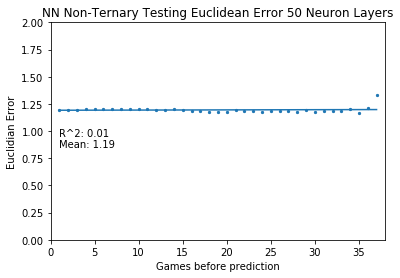

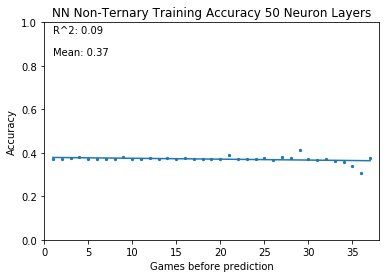

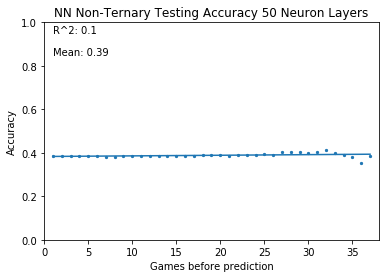

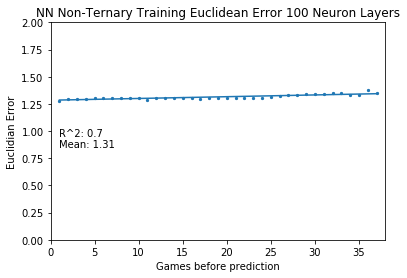

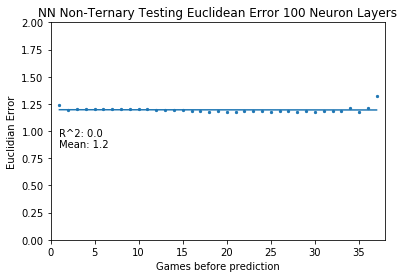

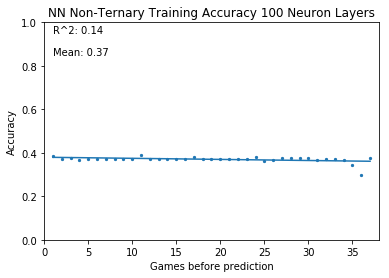

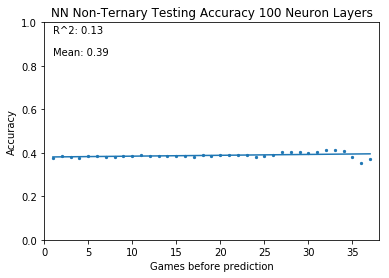

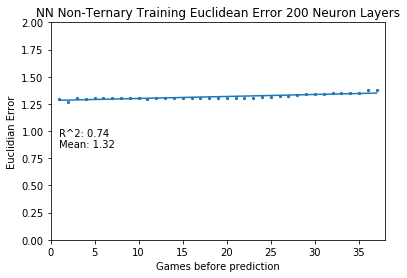

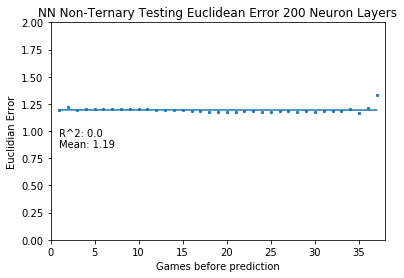

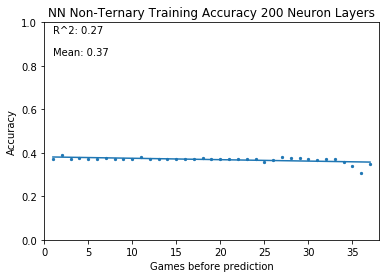

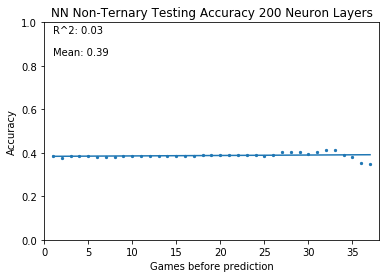

In [21]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    title = ' ' + str(size) + ' Neuron Layers'
    plot(training_errs_dict[key], 'Euclidian Error', 'NN Non-Ternary Training Euclidean Error' + title, 'nn_nt_training_error_plot_'+key, 2)
    plot(testing_errs_dict[key], 'Euclidian Error', 'NN Non-Ternary Testing Euclidean Error' + title, 'nn_nt_testing_error_plot_'+key, 2)
    plot(training_accs_dict[key], 'Accuracy', 'NN Non-Ternary Training Accuracy' + title, 'nn_training_nt_accuracy_plot_'+key, 1)
    plot(testing_accs_dict[key], 'Accuracy', 'NN Non-Ternary Testing Accuracy' + title, 'nn_nt_testing_accuracy_plot_'+key, 1)